# Disaster Tweet Classification Using LSTM – NLP

In [1]:
import warnings
warnings.simplefilter(action="ignore", category = Warning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

In [4]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

<AxesSubplot:xlabel='target', ylabel='count'>

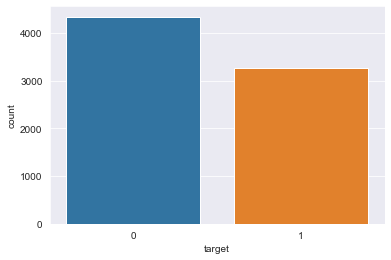

In [5]:
sns.countplot(df["target"])

In [6]:
df["target"].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

As an important step of data analysis we’re going to calculate the length of each tweets and creating a function for plotting an histogram based on the length data.

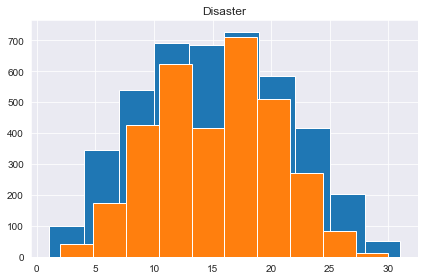

In [7]:
def length_plot(df, name):
    length = [len(sentence.split()) for sentence in df]
    plt.hist(length)
    plt.title(name)
    
length_plot(df[df["target"]==0]["text"], "Not Disaster")
length_plot(df[df["target"]==1]["text"], "Disaster")
plt.tight_layout()

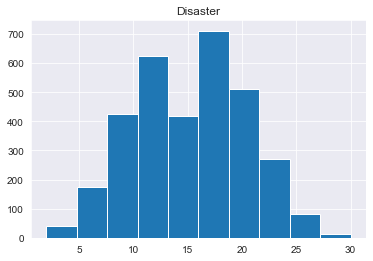

In [8]:
length_plot(df[df["target"]==1]["text"], "Disaster")

Now let’s separate the dependent and independent features

In [9]:
X = df["text"]
y = df["target"]

Calculating the number of unique words present in the disaster tweets.

In [15]:
def unique_words(sentence):
    unique_words_list = []
    for sent in tqdm(sentence):
        for word in sent.split():
            if word.lower not in unique_words_list:
                unique_words_list.append(word.lower())
            else:
                pass
    return unique_words_list

unique_words = unique_words(X)
print("Total unique words present: ", len(unique_words))

100%|██████████████████████████████████████████████████████████████████████████████| 7613/7613 [03:53<00:00, 32.59it/s]

Total unique words present:  113461


In [11]:
df.shape

(7613, 5)

In [21]:
unique_words[160:180]

['am',
 'i',
 'gonna',
 'do',
 'what',
 'am',
 'i',
 'gonna',
 'do',
 'fvck',
 '#flooding',
 '#raining',
 '#flooding',
 '#florida',
 '#tampabay',
 '#tampa',
 '18',
 'or',
 '19',
 'days.']

As you know that this is a twitter dataset, so it  might contains several words starting with ‘#’ and ‘@’. So let’s find these words words starting with “#”

In [23]:
symbol_1 = [word for word in unique_words if word.startswith("#")]
len(symbol_1)

3340

In [24]:
symbol_2 = [word for word in unique_words if word.startswith("@")]
len(symbol_2)

2664

In the dataset there are several urls are present ,so let’s write a function to remove the  urls present in it.

In [25]:
def url_remover(text):
    url_patterns = re.compile(r'https?://S+|www.S+')
    return url_patterns.sub(r'',text)

Now let’s start the actual preprocessing so we are writing a function for it.

In [26]:
from nltk.stem import WordNetLemmatizer

In [27]:
wl = WordNetLemmatizer()

In [28]:
def preprocessing(text):
    tweets = []
    for sentence in tqdm(text):
        sentence = sentence.lower()
        sentence = url_remover(sentence)
        sentence = re.sub(r'@w+','',sentence).strip()
        sentence = re.sub("[^a-zA-Z0-9']", '' ,sentence)
        sentence = sentence.split()
        sentence1 = [wl.lemmatize(word) for word in sentence if word not in set(stopwords.words("english"))]
        sentence1 = " ".join(sentence1)
        tweets.append(sentence1)
    return tweets
tweets = preprocessing(X)
        

100%|█████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:08<00:00, 930.67it/s]


Before feeding into the model all these tweets needs to be converted into numerical features. So we need to perform onehot encoding. So before that we are importing tensorflow library and its parts

In [29]:
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D, BatchNormalization)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

Now performing onehot encoding

In [33]:
voc_size = 30000
onehot_vector = [one_hot(words, voc_size) for words in tweets]

In [34]:
onehot_vector[110:130]

[[7414],
 [26493],
 [13052],
 [9124],
 [19528],
 [17476],
 [4588],
 [8322],
 [18936],
 [18936],
 [19037],
 [11163],
 [22401],
 [21742],
 [29774],
 [22009],
 [7899],
 [842],
 [10800],
 [11962]]

Let’s find the word length each for each tweets.

In [47]:
word_length = []
for i in onehot_vector:
    word_length.append(len(i))

In [40]:
len(word_length)

7613

In [43]:
max(word_length) 

1

In [48]:
SENTENCE_LENGTH = 15
embedded_docs = pad_sequences(onehot_vector, padding="post", maxlen=SENTENCE_LENGTH)
embedded_docs

array([[ 8048,     0,     0, ...,     0,     0,     0],
       [11533,     0,     0, ...,     0,     0,     0],
       [27667,     0,     0, ...,     0,     0,     0],
       ...,
       [12530,     0,     0, ...,     0,     0,     0],
       [ 1357,     0,     0, ...,     0,     0,     0],
       [14527,     0,     0, ...,     0,     0,     0]])

In [51]:
def model():
    VECTOR_FEATURES = 32
    lstm_model = Sequential()
    lstm_model.add(Embedding(voc_size,
                      VECTOR_FEATURES,
                      input_length=SENTENCE_LENGTH))
    lstm_model.add(LSTM(100, return_sequences = True))
    lstm_model.add(GlobalMaxPool1D())
    lstm_model.add(BatchNormalization())
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(10, activation="relu"))
    lstm_model.add(Dropout(0.25))
    lstm_model.add(Dense(1, activation = "sigmoid"))
    return lstm_model

In [52]:
lstm_model = model()
lstm_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
lstm_model.summary() #summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 32)            960000    
                                                                 
 lstm (LSTM)                 (None, 15, 100)           53200     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)               

In [53]:
history = lstm_model.fit(embedded_docs, y, epochs=8, batch_size=32)

Epoch 1/8
238/238 [==============================] - 14s 38ms/step - loss: 0.6866 - accuracy: 0.5556
Epoch 2/8
238/238 [==============================] - 9s 39ms/step - loss: 0.6295 - accuracy: 0.6595
Epoch 3/8
238/238 [==============================] - 9s 40ms/step - loss: 0.3162 - accuracy: 0.8911
Epoch 4/8
238/238 [==============================] - 9s 39ms/step - loss: 0.2144 - accuracy: 0.9150
Epoch 5/8
238/238 [==============================] - 9s 39ms/step - loss: 0.1518 - accuracy: 0.9274
Epoch 6/8
238/238 [==============================] - 9s 38ms/step - loss: 0.1197 - accuracy: 0.9347
Epoch 7/8
238/238 [==============================] - 9s 37ms/step - loss: 0.1161 - accuracy: 0.9354
Epoch 8/8
238/238 [==============================] - 9s 39ms/step - loss: 0.1103 - accuracy: 0.9352


Text(0.5, 1.0, 'Accuracy')

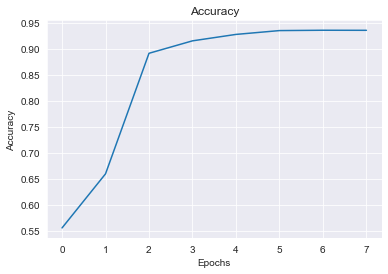

In [54]:
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")

Text(0.5, 1.0, 'Loss')

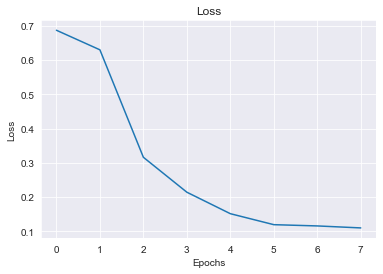

In [55]:
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")

In [57]:
#pickle.dump(lstm_model, open("model.pkl", "wb"))